#  Modello di Visione e Linguaggio

# Vision Language Models (VLMs)

# Contrastive Language-Image Pretraining (CLIP)

I Modelli di Visione e Linguaggio hanno acquisito notevole importanza in tempi recenti.

CLIP [1] è un importante Modello di Visione e Linguaggio (VLM). CLIP è preaddestrato su un ampio dataset contenente immagini e le relative descrizioni testuali associate. Questo processo di preaddestramento gli consente di comprendere le relazioni tra immagini e testo. Il modello CLIP preaddestrato può essere utilizzato in modo efficace per diverse attività successive (**downstream task**), anche in una configurazione a zero-shot.

<img src="https://github.com/openai/CLIP/raw/main/CLIP.png" width="700"></br></br>

[ENG]

Vision Language Models have gained significant importance in recent times.

CLIP [1] is an important Vision Language Model (VLM). CLIP is pre-trained on a large dataset containing images and their associated text descriptions. This pre-training process allows it to understand the relationships between images and text. The pre-trained CLIP model can be used for several downstream tasks effectively even within a zero-shot setting.

[1] Alec Radford, et al. Learning transferable visual models from natural language supervision. In ICML, 2021.

## Setup
Per usare CLIP, Iniziamo con l'installazione dei pacchetti necessari.

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 748.0 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-j16h60wh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-j16h60wh
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=5b5bde354e014d8dd2e8d1ce05a9f6e0f5296fbd1cb828bf515f2c58ea96f0e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-lx99g0my/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


Adesso, possiamo importare tutti i pacchetti rilevanti:

In [1]:
import numpy as np
import torch
import torchvision

from clip import clip

Visualizziamo i modelli CLIP preaddestrati disponibili:

In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

Posiamo utilizzare la funzione `clip.load()` e specificare il nome del modello che vogliamo utilizzare.

[ENG]
We can use the `clip.load()` function and specify the name of the model we want to use.

In [ ]:
model, preprocess = clip.load("RN50") # Carica un modello CLIP preaddestrato ResNet50 e lo assegna alla variabile model
                                      # preprocess contene la funzione di pre-elaborazione (es. center crop, resize, toTensor)
model = model.cuda().eval() # Imposta il modello in modalità di valutazione (inference stage)
                            # Indica che il modello non dovrebbe aggiornare i suoi pesi e dovrebbe comportarsi come se fosse utilizzato per la previsione

100%|███████████████████████████████████████| 244M/244M [00:16<00:00, 15.6MiB/s]


Vediamo la struttura dell'architettura che abbiamo caricato.

[ENG] Let's see the structure of the architecture we loaded.

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {trainable_params}')

Number of trainable parameters: 102007137


In [ ]:
input_resolution = model.visual.input_resolution # "image_resolution" contiene la risoluzione dell'input visivo (immagini) accettata dal modello CLIP
context_length = model.context_length # quante parole o simboli il modello CLIP può considerare durante "natural langiage processing"
vocab_size = model.vocab_size # il numero di parole o simboli che il modello può comprendere e utilizzare per l'elaborazione del testo

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


## Valutazione a Zero Colpi (Zero-shot Evaluation)

Con CLIP, possiamo svolgere diverse attività senza ulteriori addestramenti o fine-tuning su dataset particolari.

Per farlo, abbiamo bisogno di alcuni dati di test. I dati di test devono essere preelaborati come richiesto da CLIP. Queste informazioni sulla pre-elaborazione possono essere trovate in `preprocess`, che viene caricato chiamando la funzione `clip.load()`.

[ENG]

With CLIP, we can perform different tasks without additional training or fine-tuning on specific datasets.

To do so, we need some test data. The test data should preprocessed as CLIP requires. This preprocessing information can be found in `preprocess` that is loaded by calling `clip.load()` function.


In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f08f889acb0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


Possiamo utilizzare la trasformazione `preprocess` per convertire le immagini di tipo `PIL.Image` in tensori compatibili con CLIP.

**!!!** Tuttavia, per i dati testuali, non possiamo applicare le stesse trasformazioni. Invece, possiamo utilizzare la funzione `clip.tokenize()`, che accetta input testuali e li converte in un tensore di interi.


[ENG]

We can use the `preprocess` transform to convert `PIL.Image`s into tensors that are compatible with CLIP.

**!!!** However, for the textual data, we cannot apply the same transformations. Instead, we can use the `clip.tokenize()` function, which gets textual input and converts it into an integer tensor.

In [ ]:
clip.tokenize("tokenize me!")

tensor([[49406, 32634, 10885,   614,   256, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [ ]:
clip.tokenize("tokenize me")

tensor([[49406, 32634, 10885,   614, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

Verifichiamo le prestazioni di CLIP su alcune immagini e testi.

Prima di farlo, dobbiamo importare altri pacchetti di cui abbiamo bisogno.

[ENG]

Let's check the performance of CLIP on some images and texts.

Before that, we need to import other packages we need.


In [ ]:
from collections import OrderedDict # OrderedDict ricorda l'ordine in cui sono stati aggiunti gli elementi
from pathlib import Path # Path è utilizzata per lavorare con percorsi del file system e directory

import skimage # è utilizzato per compiti di elaborazione delle immagini (Image processing)
import IPython.display # consente la visualizzazione e il rendering interattivi di oggetti nei notebook Jupyter
import matplotlib.pyplot as plt # è utilizzato per creare e visualizzare grafici e figure
from PIL import Image # è utilizzata per lavorare con immagini in vari formati

#........ comando magico di Jupyter Notebook (MAGIC FUNCTIONS)....................
# inline: configura Matplotlib per visualizzare i grafici direttamente nel notebook
# InlineBackend.figure_format: configura il formato delle figure per una visualizzazione ad alta risoluzione
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Definiamo i nostri dati e visualizziamoli insieme alla loro descrizione testuale.

[ENG] Let's define our data and visualize together with their text description.

In [ ]:
# Crea una descrizione per alcune immagini
# Crea un dizionario denominato "DESCRIPTIONS" con chiavi e descrizioni associate
DESCRIPTIONS = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

# In questo esempio, "DESCRIPTIONS" rappresentano i nomi associati alle immagini.
# Quindi, le chiavi del dizionario "DESCRIPTIONS" corrispondono ai nomi delle immagini.


def get_data():
  images = []
  texts = []

  # Ottiene tutti i nomi dei file nella directory dei dati
  data_dir = Path(skimage.data_dir)
  filenames = [
    filename for filename in data_dir.glob('*') # glob('*') per recuperare tutti i file nella directory.
    if filename.suffix in {'.png', '.jpg'} # filtra i nomi dei file in base alle loro estensioni '.png' o '.jpg'
  ]

  for filename in filenames:
    # Saltare le immagini a cui non siamo interessati (skip images we do not care about)
    name = filename.stem  #  "filename" rappresenta il nome completo di un file, compreso il percorso (path) e l'estensione
                          # "stem" restituisce solo il nome del file, eliminando il path e l'estensione.
    if name not in DESCRIPTIONS:
        continue

    # Memorizzare i dati
    images.append(filename)
    texts.append(DESCRIPTIONS[name]) # Nota che name è chiavi del dizionario

  return images, texts

def visualise_data(images_fp: list[str], texts: list[str]):
  # Creare un oggetto figura Matplotlib
  plt.figure(figsize=(16, 5))

  for i, (image_fp, text) in enumerate(zip(images_fp, texts)):
    # La funzione "zip" combina due elenchi (images_fp e texts) in modo che vengano affiancati in coppie
    # Possiamo accedere a un percorso di immagine e al testo corrispondente contemporaneamente
    image = Image.open(image_fp).convert("RGB") # carica un'immagine e converti nel formato RGB

    # Visualizzare l'immagine
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(text) # Il titolo della figura è la descrizione testuale
    plt.xticks([])
    plt.yticks([])
  plt.tight_layout()

images_fp, texts = get_data()
visualise_data(images_fp, texts)

Output hidden; open in https://colab.research.google.com to view.

# Otteniamo le caratteristiche CLIP (rappresentazioni codificate -- encoded representations) per i nostri dati di test

Ricordatevi di utilizzare `preprocess` e `clip.tokenize`.

[ENG]

Let's obtain the CLIP features (encoded representations) for our test data. Remember to use  `preprocess` and  `clip.tokenize`.


In [ ]:
def encode_data(images_fp: list[str], texts: list[str]):
  # Elaborare le immagini per trasformarle dai nomi dei file in immagini e tensori
  # Elaborare le immagini per trasformarle filename -> immagini -> tensori
  images = [preprocess(Image.open(image)) for image in images_fp]
  images = torch.tensor(np.stack(images)).cuda()

  # Elaborare i testi per trasformarli da testo a tensori : testo -> tensori
  text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

  # Codificare gli input (encode the inputs)
  with torch.no_grad(): # ATTENZIONE! senza calcolare gradienti
    images_z = model.encode_image(images).float()
    texts_z = model.encode_text(text_tokens).float()

  return images_z, texts_z

# Valutiamo la similarità tra il set di immagini e il set di testi

È molto importante **normalizzare** le caratteristiche per renderle 'compatibili' e facilitare il ragionamento nello spazio delle caratteristiche.

Utilizziamo la **similarità cosinica**, che è molto comune nelle applicazioni di CLIP.


[ENG]

We can now evaluate the similarity between the set of images and the set of textual descriptions that we created. We can expect that the similarity will be higher for the pairs that we plotted earlier.

Initially, **it is vital** to normalize the features to make them "compatible" and facilitate reasoning in the feature space.

We use **cosine similarity** which is very common for CLIP applications.

In [ ]:
def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
  ''' normalizza l'immagine e il testo
      Normalizzazione L2:
      Le immagini/testi vengono normalizzate dividendo ciascuna immagine/testi ...
      per la norma lungo l'asse specificato (-1: ultima dimensione), mantenendo le dimensioni
  '''
  images_z /= images_z.norm(dim=-1, keepdim=True)
  texts_z /= texts_z.norm(dim=-1, keepdim=True)

  # Valutare la similarità cosinica tra i set di caratteristiche
  similarity = (texts_z @ images_z.T) # ".T": trasposta (transpose), @: moltiplicazione tra matrici o prodotto dot
  # I valori più grandi di "similarity" indicano che i dati testuali e le immagini sono più simili

  return similarity.cpu()

images_fp, texts = get_data()
images_z, texts_z = encode_data(images_fp, texts)
similarity = cosine_similarity(images_z, texts_z)
print(similarity)

tensor([[0.2702, 0.0486, 0.1017, 0.0486, 0.0922, 0.0546, 0.0840, 0.1141],
        [0.1193, 0.2360, 0.1654, 0.1807, 0.1458, 0.1111, 0.1039, 0.1244],
        [0.0738, 0.1549, 0.2296, 0.1436, 0.0978, 0.0752, 0.0867, 0.1075],
        [0.0814, 0.1317, 0.1296, 0.2396, 0.1674, 0.1260, 0.1225, 0.1409],
        [0.0716, 0.0917, 0.1455, 0.1155, 0.2613, 0.1319, 0.1370, 0.1205],
        [0.0796, 0.1036, 0.1018, 0.1196, 0.1454, 0.2771, 0.1396, 0.1413],
        [0.0833, 0.0698, 0.1114, 0.1126, 0.1352, 0.1171, 0.2437, 0.1093],
        [0.0627, 0.0773, 0.0756, 0.1556, 0.0760, 0.1525, 0.1069, 0.2969]])


La similarità è più alta sulla diagonale. Ricorda che le coppie sulla diagonale sono le coppie immagine-testo che abbiamo rappresentato precedentemente.

[ENG]
The similarity is higher on the diagonal. Remember that the couples in the diagonal are the image-text pairs we plotted above.



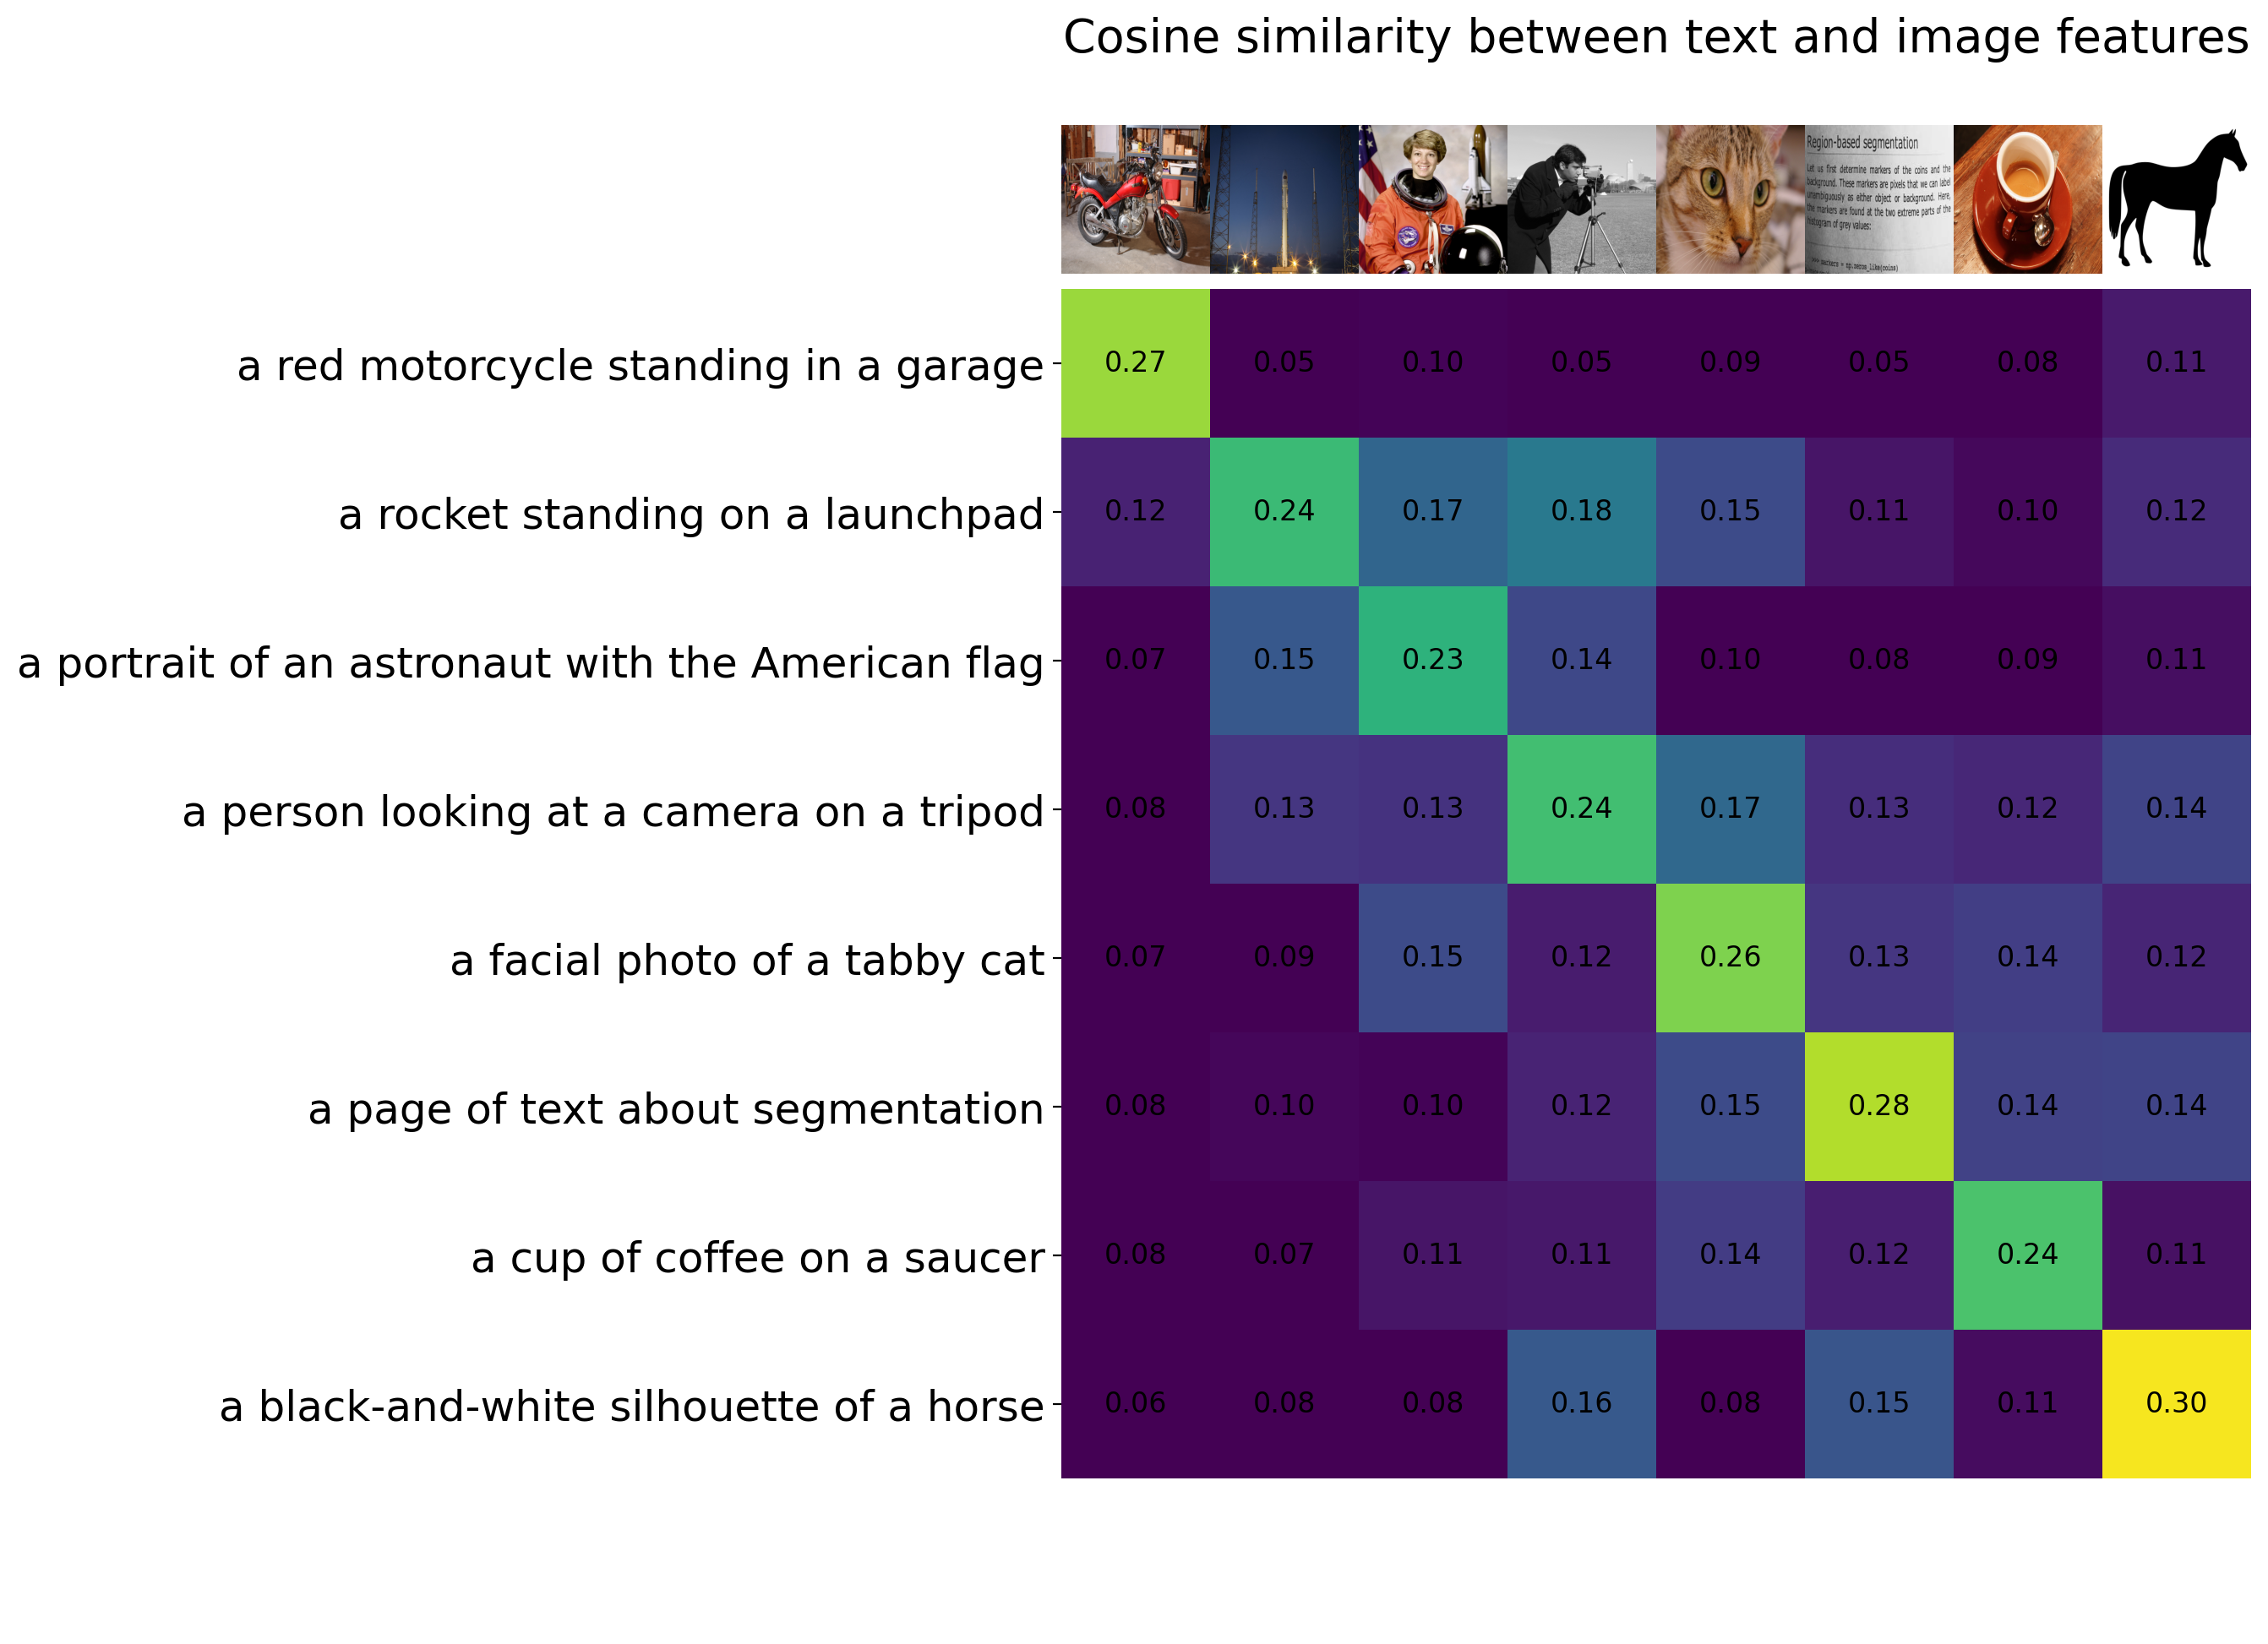

In [ ]:
# Visualizziamo i valori di similarità

def visualise_similarity(similarity: torch.Tensor, images_fp: list[str], texts: list[str]):
  similarity = similarity.numpy()
  count = len(texts)

  # crea un oggetto figura di Matplotlib (create a matplotlib figure object)
  plt.figure(figsize=(18, 12))

  # mostra i punteggi di similarità (show similarity scores)
  plt.imshow(similarity, vmin=0.1, vmax=0.3) # La matrice di similarità viene visualizzata come un'immagine
                                             # vmin:  il valore minimo per la scala dei colori dell'immagine
                                             # vmax:  il valore massimo per la scala dei colori dell'immagine

  # aggiorna le etichette del grafico (update plot ticks)
  plt.yticks(range(count), texts, fontsize=18) # Le etichette sull'asse y vengono impostate con le descrizioni di testo
  plt.xticks([]) # mentre l'asse x viene svuotato (cleared)

  # visualizza ciascuna immagine (visualise each image)
  for i, image_fp in enumerate(images_fp):
    image = Image.open(image_fp).convert("RGB")
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

  # stampa i punteggi (print the scores)
  # I punteggi di similarità vengono stampati sopra le celle corrispondenti nella matrice
  for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
      plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

  # aggiorna le linee di separazione (update spines)
  for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False) # Le linee di separazione (spines) del grafico vengono nascoste (hidden)

  # modifica i limiti del grafico (change plot limits)
  plt.xlim([-0.5, count - 0.5])
  plt.ylim([count + 0.5, -2])

  # imposta il titolo (set title)
  plt.title("Cosine similarity between text and image features", size=20)

visualise_similarity(similarity, images_fp, texts)

# Possiamo utilizzare i punteggi di SIMILARITÀ per la classificazione?

Invece di avere descrizioni come "a cup of coffee on a saucer", possiamo avere descrizioni che coinvolgono l'ETICHETTA (horse, person, mug) di un oggetto. Ad esempio:
* a photo of a horse
* a photo of a person
* a photo of a mug

In casi come questi, confrontando queste descrizioni con l'immagine e raccogliendo i punteggi di similarità, possiamo classificare direttamente un'immagine come 'a mug' se il punteggio per 'un mug' è il più alto nell'insieme di descrizioni.

Esploriamo ulteriormente questo concetto con un esempio sul dataset CIFAR10.


[ENG]

# Can we use SIMILARITY scores for classification?

Instead of having descriptions like "a cup of coffee on a saucer", what if we have descriptions involving the LABEL (horse, person, mug) of an object. Such as:
* a photo of a horse
* a photo of a person
* a photo of a mug

In such cases by comparing these descriptions with the image and collecting similarity scores, we can directly classify an image as "a mug" if the score for "the mug" is the highest in the description set.

Let's explore this further with an example on CIFAR10.

Files already downloaded and verified


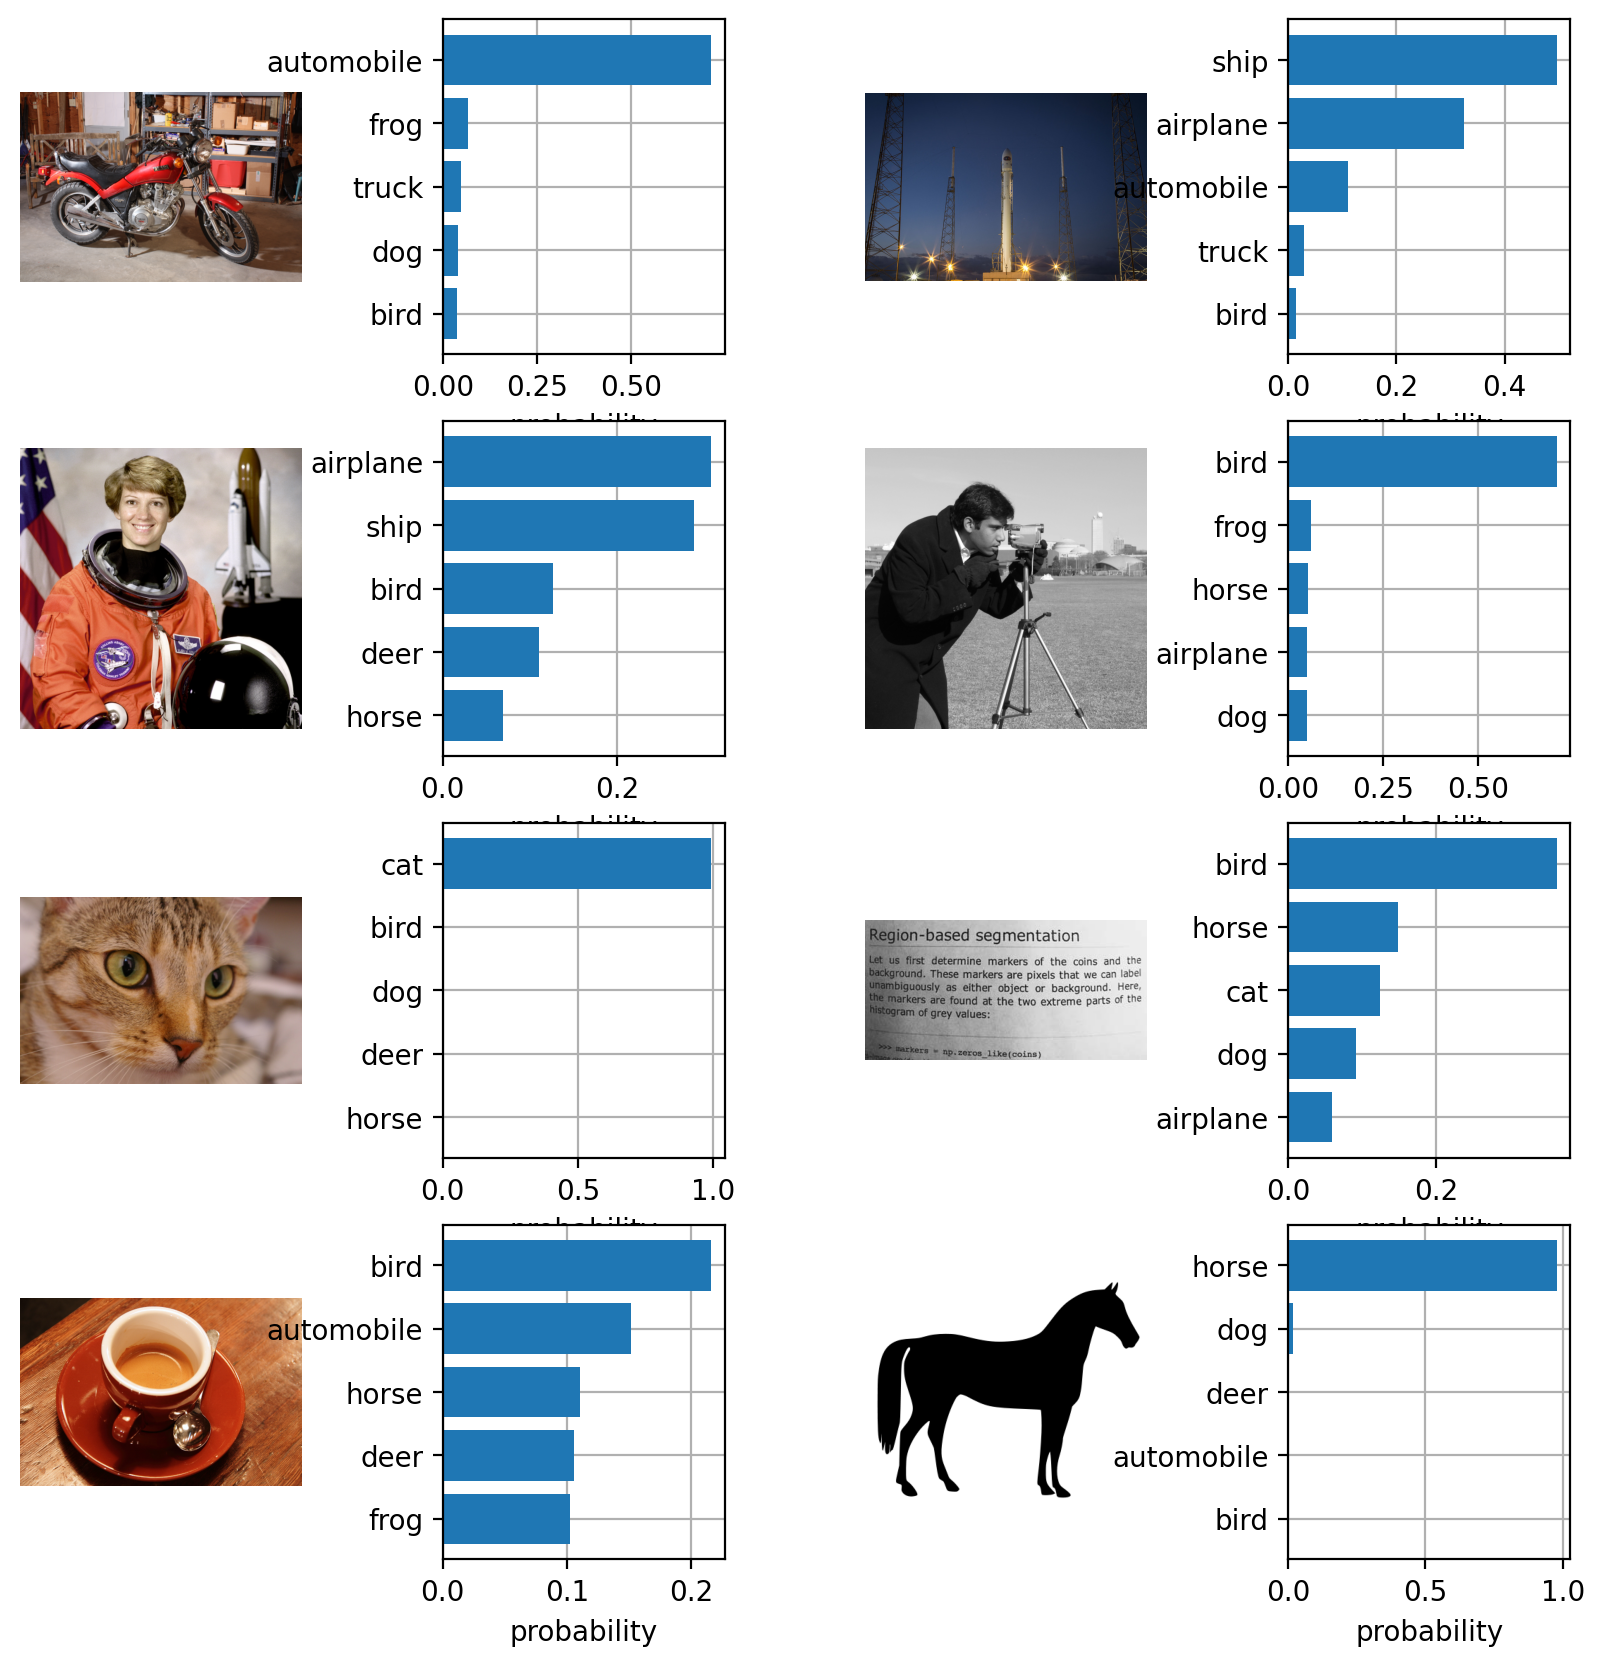

In [ ]:
# Abbiamo creato questo dizionario "DATASETS" per ottenere le classi (etichette) del dataset CIFAR10 utilizzando DATASETS["cifar10"]
DATASETS = {
    "mnist": torchvision.datasets.MNIST,
    "cifar10": torchvision.datasets.CIFAR10,
    "cifar100": torchvision.datasets.CIFAR100,
}

def embed_dataset_classnames(dataset_name: str):
  Dataset = DATASETS[dataset_name] #es. DATASETS["cifar10"]

  # Crea l'elenco delle descrizioni e tokenizzale (create the list of descriptions and tokenise them)
  dataset = Dataset("./data", transform=preprocess, download=True, train=False)
  classnames = dataset.classes
  # PROMPT: a photo of a [CLS]
  descriptions = [f"a photo of a {label}." for label in classnames] # Crea l'elenco delle descrizioni con le etichette
  text_tokens = clip.tokenize(descriptions).cuda() # Tokenizza le descrizioni

  with torch.no_grad():
      texts_z = model.encode_text(text_tokens).float() # estrarre le caratteristiche del testo (embeddings)
      texts_z /= texts_z.norm(dim=-1, keepdim=True) # normalizzare le caratteristiche testuali

  return classnames, texts_z

def visualise_probabilities(
    images_fp: list[str], classnames: list[str], texts_p: torch.Tensor, k: int = 5
  ):
  # images_fp: una lista di percorsi delle immagini
  # classnames: una lista di nomi delle classi
  # texts_p: similarità cosinus
  # k: il numero massimo di classificazioni da visualizzare

  # Determina le classi più probabili associate alle immagini in esame
  # "topk": è una funzione che calcola i migliori k valori in un tensore lungo etichette
  # "topk_p" contiene i punteggi dei k valori più alti
  # "topk_labels" contiene le etichette associate a questi k valori più alti
  topk_p, topk_labels = texts_p.cpu().topk(k, dim=-1)

  # Creare un oggetto figura di Matplotlib
  plt.figure(figsize=(10, 10))

  for i, image_fp in enumerate(images_fp):

    image = Image.open(image_fp).convert("RGB")

    # Visualizza l'immagine
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    # Visualizzare le probabilità per l'immagine
    plt.subplot(4, 4, 2 * i + 2) # Griglia (grid) di sottografici 4x4, "2 * i + 2" indice del sottografico
    y = np.arange(topk_p.shape[-1]) #restituisce una sequenza di numeri da 0 al numero delle probabilità principali ("k")
    plt.grid()
    plt.barh(y, topk_p[i]) # Crea un grafico a barre orizzontali in cui "y" rappresenta le etichette di classe
                           # e "topk_p[i]" rappresenta le probabilità principali per l'immagine "i"
    plt.gca().invert_yaxis() # Inverte l'asse delle y in modo che le classi con probabilità più alte siano nella parte superiore del grafico
    plt.gca().set_axisbelow(True)
    # "yticks" imposta le etichette sull'asse delle y utilizzando i nomi delle classi corrispondenti ai "topk_labels" dell'immagine "i"
    plt.yticks(y, [classnames[index] for index in topk_labels[i].numpy()])
    plt.xlabel("probability")

  plt.subplots_adjust(wspace=0.5)
  plt.show()


# ottene le descrizioni di testo e i loro embedding
texts, texts_z = embed_dataset_classnames("cifar10")

# !!!!!!!!!!!!!!calcola la funzione SOFTMAX dalle similarità cosiniche !!!!!!!!!!!!!
similarity = cosine_similarity(texts_z, images_z)
texts_p = (100 * similarity).softmax(dim=-1) # converte i punteggi di similarità in punteggi di probabilità con softmax

# visualizza le prime 5 previsioni
visualise_probabilities(images_fp, texts, texts_p, k=5)

## Alcune considerazioni

Finora abbiamo utilizzato descrizioni testuali per classificare le immagini utilizzando CLIP. Tuttavia, l'opposto è anch'esso possibile. Possiamo utilizzare immagini per classificare il testo. Inoltre, possiamo confrontare la similarità tra immagini o la similarità tra testi.

[ENG]

## Some considerations

So far, we used textual descriptions to classify images using CLIP. But, the opposite is also possible. Furthermore, we can compare the similarity netwen images or similarity between text.

In [ ]:
# confrontare quanto un testo è simile ad altri testi
similarity = cosine_similarity(texts_z, texts_z)
print(similarity)

# confrontare quanto le immagini sono simili tra loro
similarity = cosine_similarity(images_z, images_z)
print(similarity)

tensor([[1.0000, 0.8933, 0.8919, 0.8693, 0.8202, 0.8780, 0.7961, 0.8648, 0.8944,
         0.8746],
        [0.8933, 1.0000, 0.8733, 0.8680, 0.8075, 0.8789, 0.7814, 0.8646, 0.8848,
         0.9219],
        [0.8919, 0.8733, 1.0000, 0.9138, 0.8642, 0.9087, 0.8555, 0.8967, 0.8719,
         0.8592],
        [0.8693, 0.8680, 0.9138, 1.0000, 0.8574, 0.9308, 0.8334, 0.8915, 0.8564,
         0.8522],
        [0.8202, 0.8075, 0.8642, 0.8574, 1.0000, 0.8743, 0.8131, 0.8644, 0.8136,
         0.8102],
        [0.8780, 0.8789, 0.9087, 0.9308, 0.8743, 1.0000, 0.8524, 0.9152, 0.8627,
         0.8727],
        [0.7961, 0.7814, 0.8555, 0.8334, 0.8131, 0.8524, 1.0000, 0.8283, 0.7824,
         0.7851],
        [0.8648, 0.8646, 0.8967, 0.8915, 0.8644, 0.9152, 0.8283, 1.0000, 0.8572,
         0.8569],
        [0.8944, 0.8848, 0.8719, 0.8564, 0.8136, 0.8627, 0.7824, 0.8572, 1.0000,
         0.8791],
        [0.8746, 0.9219, 0.8592, 0.8522, 0.8102, 0.8727, 0.7851, 0.8569, 0.8791,
         1.0000]])
tensor([[

# Esercizio 1

In precedenza, abbiamo considerato solo un singolo "prompt" per ciascun nome di classe (cioè, "una foto di un [CLS]"), ma possiamo utilizzare più prompt per generare più caratteristiche testuali.

In questo caso, possiamo utilizzare la media delle caratteristiche testuali. L'applicazione di questa tecnica può migliorare le prestazioni di classificazione.

Riscrivere la funzione `embed_dataset_classnames` in modo che accetti più di un `prompt` per una singola classe di oggetti come segue:

"a photo of a [CLS]."

"a low-res picture of a [CLS]."

Puoi usare `template.format(c)` per sostituire [CLS] con il nome della classe dell'immagine (oggetto).

Per calcolare la media dei dati di testo codificati, puoi usare `torch.stack(texts_z_views).mean(dim=0)`.


[ENG]

Previosuly, we considered only a single "prompt" for each class name (i.e., "a photo of a [CLS]"), but we can use multiple templates to generate more textual features.

For example, we can use **mean** of the textual features. Applying this can improve the classification performance.

Re-write the `embed_dataset_classnames` function such that it takes more than one `prompt` for a single class of object as follow.

"a photo of a [CLS]."

"a low-res picture of a [CLS]."

You can use `template.format(c)` to replace [CLS] with the class name of the image (object).

To calculate the mean of encoded text data you can use `torch.stack(texts_z_views).mean(dim=0)`.



# Finetuning CLIP

Nota che CLIP non dispone di strati lineari (linear layers) per eseguire, ad esempio, la classificazione. Ciò è dovuto al fatto che CLIP è una metodologia di preaddestramento.
Tuttavia, possiamo utilizzare CLIP per diverse applicazioni (downstream tasks) aggiungendo strati lineari.

Consideriamo un esempio con MNIST. Per farlo, riutilizzeremo il codice delle lezioni di laboratorio precedenti.

[ENG]

Notice that CLIP does not have linear layer to perform classification. This is becasue CLIP is a pretraining methodology.
However, we can use CLIP for several applications (donwstream tasks) by adding linear layers.

Let's consider an example with MNIST. To do this, we will reuse code from previous lab lessons.

In [ ]:
# Modificare la funzione get_data poiché CLIP ha la sua
# Modify the get_data function since CLIP has its own

def get_data(dataset_name, batch_size=64, transform=None, test_batch_size=256):
  dataset = DATASETS[dataset_name]

  if not transform: # Se la trasformazione non è specificata
    # convertire le immagini PIL in tensori (convert the PIL images to Tensors)
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

  # carica i dati
  full_training_data = dataset('./data', train=True, transform=transform, download=True)
  test_data = dataset('./data', train=False, transform=transform, download=True)

  # crea divisioni per l'addestramento e la validazione: 50% dei dati per l'addestramento, 50% per la validazione
  num_samples = len(full_training_data)
  training_samples = int(num_samples * 0.5 + 1)
  validation_samples = num_samples - training_samples
  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # inizializzare i dataloader
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [ ]:
# Scrivere un test_step per valutare le prestazioni di CLIP in una situazione di zero-shot
# Write a test_step to evaluate how well zero-shot CLIP performs

def test_step_zero_shot_clip(net, data_loader, texts_z, device='cuda'):
  samples = 0.0
  cumulative_accuracy = 0.0

  # impostare la rete in modalità di valutazione (set the network to evaluation mode)
  net.eval()

  # disabilitare il calcolo del gradiente poiché stiamo solo testando
  # disable gradient computation because we are only testing
  with torch.no_grad():
    # iterare sul set di test
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # carica i dati nella GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # forward pass
      images_z = model.encode_image(inputs).float() # ATTENZIONE: Questo è diverso da altri modelli, ad esempio MLP e CNN
      ''' Estrarre le rappresentazioni delle immagini dall'encoder di immagini di CLIP (Extract image embeddings from image encoder of CLIP)
          Ricorda che la funzione 'embed_dataset_classnames' estrarrà già le rappresentazioni dei testi.
          Recall that the function "embed_dataset_classnames" will extract text embeddings already
      '''
      # @ sugnifica prodotto scalare (dot product)
      outputs = (100 * images_z @ texts_z.T).softmax(dim=-1) # ATTENZIONE: Questo è diverso da altri modelli, ad esempio MLP e CNN

      samples += inputs.shape[0] # "samples" tiene quante immagini sono presenti in ciascun batch
      _, predicted = outputs.max(1) # outputs.max(1) restituisce il valore massimo lungo la dimensione 1 (massima probabilità)
                                    # L'underscore (_) indica che non ci interessa il valore massimo
                                    # ci interessa solo l'indice della classe prevista

      # Calcolare l'accuratezza
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_accuracy / samples * 100

In [ ]:
# Evaluate CLIP zero-shor performances on a dataset (CIFAR10 in our case)
dataset_name = "cifar10"

_, _, test_loader = get_data(dataset_name, transform=preprocess, batch_size=128)
texts, texts_z = embed_dataset_classnames(dataset_name) # questa funzione trova gli embedding per i dati testuali (this function find the embeddings of the text data)
test_accuracy = test_step_zero_shot_clip(model, test_loader, texts_z)

print("Test accuracy {:.2f}".format(test_accuracy))

# Aggiungere uno strato lineare sopra a FROZEN CLIP (encoder visuale)

Aggiungiamo uno strato lineare sopra al **encoder** (codificatore) **visuale di CLIP**.

Il primo passo consiste nel **creare una rete neurale personalizzata** che si basa sul codificatore visuale.

[ENG]

# Adding Linear Layer on top of Frozen CLIP (visual encoder)
Let's add a linear layer on top of the **visual encoder** of CLIP.

The initial step is to create a custom neural network that builds upon the visual encoder.

In [8]:
# Creare una rete neurale
# Visual Encoder  N° of parameters
# RN50:           38'327'146
# RN101:          56'270'186
# ViT-B/16:       86'202'890
# RN50x4:         87'147'330
# ViT-B/32:       87'859'466
# RN50x16:        167'339'162
# ViT-L/14:       303'976'458
# RN50x64:        420'390'602

class CustomCLIP(torch.nn.Module):
  def __init__(self, num_classes: int = 10):
    super().__init__()
    model, _ = clip.load("RN50x16")

    # modal.visual: prendere il codificatore visuale di CLIP (visual encoder of CLIP)
    # float: l'encoder è convertito a 32 bit poiché il CLIP predefinito è a 16 bit
    self.encoder = model.visual.float()

    # aggiunge uno strato lineare (add a single linear layer)
    self.classifier = torch.nn.Linear(1024, num_classes)

  # Il simbolo -> viene utilizzato per specificare il tipo di valore restituito dalla funzione
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.encoder(x)
    x = self.classifier(x)

    return x

In [9]:
net = CustomCLIP(num_classes=10).to("cuda")
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {trainable_params}')

100%|███████████████████████████████████████| 630M/630M [00:07<00:00, 83.4MiB/s]


Number of trainable parameters: 167339162


Definiamo l'ottimizzatore, la funzione di perdita e le fasi di addestramento e test.

[ENG]

Let's define the optimizer, the loss function, and the training and testing steps.

In [ ]:
def get_optimizer(model, lr, wd, momentum):
  optimizer = torch.optim.SGD([
      {'params': model.classifier.parameters(), 'lr': lr}
  ], lr=lr / 10, weight_decay=wd, momentum=momentum)

  return optimizer

In [ ]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

In [ ]:
def training_step(net, data_loader, optimizer, cost_function, device='cuda'):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  # impostare la rete in modalità di addestramento (set the network to training mode)
  net.train()

  # iterare sul set di addestramento
  for batch_idx, (inputs, targets) in enumerate(data_loader):

    inputs = inputs.to(device)
    targets = targets.to(device)

    # passaggio in avanti (forward pass)
    outputs = net(inputs)

    # calcolo della perdita (loss computation)
    loss = cost_function(outputs, targets)
    #outputs sono i RAW LOGITS, targets deve essere una lista o tensore di len=batch_size contenente le classi vere del batch

    # passaggio all'indietro (backward pass)
    loss.backward()

    # aggiorna dei parametri (parameters update)
    optimizer.step()

    # reset dei gradienti (gradients reset)
    optimizer.zero_grad()

    # calcola delle previsioni e del valore della perdita (calculate prediction and loss value)
    samples += inputs.shape[0]
    cumulative_loss += loss.item() # ".item()" è necessario per estrarre scalari dai tensori
    _, predicted = outputs.max(dim=1)

    # calcola l'accuratezza dell'addestramento (compute training accuracy)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss / samples, cumulative_accuracy / samples * 100

def test_step(net, data_loader, cost_function, device='cuda'):
  samples = 0.0
  cumulative_loss = 0.0
  cumulative_accuracy = 0.0

  # impostare la rete in modalità di valutazione (set the network to evaluation mode)
  net.eval()

  # disabilitare il calcolo del gradiente poiché stiamo solo testando
  with torch.no_grad():
    # iterare sul set di test
    for batch_idx, (inputs, targets) in enumerate(data_loader):

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = net(inputs)

      loss = cost_function(outputs, targets)

      samples += inputs.shape[0]
      cumulative_loss += loss.item()
      _, predicted = outputs.max(1)

      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss / samples, cumulative_accuracy / samples * 100

## Scriviamo la funzione PRINCIPALE

Let's write MAIN function

In [ ]:
''' TensorBoard (SummaryWriter) fornisce strumenti di visualizzazione per esaminare dati durante l'addestramento dei modelli.
    TensorBoard provides visualization tools to interactively examine this data during model training.
'''

from torch.utils.tensorboard import SummaryWriter

# manteniamo il registro di passo (step, epoca), valore della perdita e accuratezza utilizzando SummaryWriter
# tensorboard logging utilities, we keep the log of step (epoch), loss value and accuracy using SummaryWriter
def log_values(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)

# la funzione principale
def main(
      dataset_name="cifar10",
      batch_size=128,
      num_classes=10,
      device='cuda:0',
      learning_rate=0.01,
      weight_decay=0.000001,
      momentum=0.9,
      epochs=10,
    ):
  # Crea un registro (variabile "writer") da utilizzare con la funzione log_values
  # create a logger (writer variable) to use with log_values function
  writer = SummaryWriter(log_dir="runs/exp1")

  # ottieni dataloaders
  train_loader, val_loader, test_loader = get_data(
    dataset_name, transform=preprocess, batch_size=batch_size,
  )

  # istanzia la rete e spostala sul dispositivo scelto (GPU)
  net = CustomCLIP(num_classes=num_classes).to(device)

  # istanzia l'ottimizzatore
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  # definisce la funzione di costo
  cost_function = get_cost_function()

  # calcola i risultati di valutazione prima dell'addestramento
  # computes evaluation results before training
  print('Before training:')
  train_loss, train_accuracy = test_step(net, train_loader, cost_function)
  val_loss, val_accuracy = test_step(net, val_loader, cost_function)
  test_loss, test_accuracy = test_step(net, test_loader, cost_function)

  # registra su TensorBoard (log to TensorBoard)
  log_values(writer, -1, train_loss, train_accuracy, "train") # def log_values(writer, step, loss, accuracy, prefix)
  log_values(writer, -1, val_loss, val_accuracy, "validation")
  log_values(writer, -1, test_loss, test_accuracy, "test")

  print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  # per ogni epoca, addestra la rete e quindi calcola i risultati di valutazione
  for e in range(epochs):

    train_loss, train_accuracy = training_step(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test_step(net, val_loader, cost_function)

    # registra su TensorBoard
    log_values(writer, e, val_loss, val_accuracy, "Validation") # def log_values(writer, step, loss, accuracy, prefix)

    print('Epoch: {:d}'.format(e+1))
    print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  # calcola i risultati finali della valutazione
  print('After training:')
  train_loss, train_accuracy = test_step(net, train_loader, cost_function)
  val_loss, val_accuracy = test_step(net, val_loader, cost_function)
  test_loss, test_accuracy = test_step(net, test_loader, cost_function)

  # registra su TensorBoard
  log_values(writer, epochs, train_loss, train_accuracy, "train") # def log_values(writer, step, loss, accuracy, prefix)
  log_values(writer, epochs, val_loss, val_accuracy, "validation")
  log_values(writer, epochs, test_loss, test_accuracy, "test")

  print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  # chiude il registro (closes the logger)
  writer.close()

In [ ]:
!rm -r runs

rm: cannot remove 'runs': No such file or directory


In [ ]:
main()

Files already downloaded and verified
Files already downloaded and verified
Before training:
	Training loss 0.01806, Training accuracy 9.12
	Validation loss 0.00903, Validation accuracy 8.71
	Test loss 0.00921, Test accuracy 8.56
-----------------------------------------------------
Epoch: 1
	Training loss 0.01745, Training accuracy 37.17
	Validation loss 0.00842, Validation accuracy 43.87
-----------------------------------------------------


KeyboardInterrupt: ignored

# Bootstrapping Language-Image Pre-training (BLIP)

Un altro esempio di modello per il linguaggio e la visione è BLIP [2]. BLIP ha tratto ispirazione da CLIP, ma l'obiettivo della sua formazione è leggermente diverso. Le sue capacità variano rispetto a CLIP, ad esempio "Visual Question Answering".

[ENG]

Another example foundation model for language and vision is BLIP [2]. BLIP got some inspiration from CLIP, but its training objective differs slightly. Its capabilities vary from CLIP, such as "Visual Question Answering".

[2] Li, Junnan, et al. "Blip: Bootstrapping language-image pre-training for unified vision-language understanding and generation." International Conference on Machine Learning. PMLR, 2022.

## Setup
Per usare BLIP, iniziamo con l'installazione dei pacchetti necessari.

In [ ]:
!pip install salesforce-lavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 29.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 10.9 MB/s eta 0:00:00
     ━━━━

Ora possiamo importare tutti i pacchetti pertinenti.

[ENG] We can now import all the pertinent packages.

In [ ]:
import lavis # Lavis è il pacchetto del modello BLIP

Inoltre, caricheremo un'immagine di esempio per esaminare le funzionalità di BLIP.

<img src="https://upload.wikimedia.org/wikipedia/commons/5/53/Colosseum_in_Rome%2C_Italy_-_April_2007.jpg" width="500" calss="center"></br></br>


[ENG] Additionally, we will load a sample image to investigate BLIP's functionalities.

In [ ]:
import locale # per accedere alle impostazioni locali dell'utente

import gdown #  una libreria Python utilizzata per scaricare file da Google Drive (nel nostro caso abbiamo un "Wiki views" per Google Drive)

from PIL import Image

locale.getpreferredencoding = lambda: "UTF-8" # Il programma utilizza sempre UTF-8 per la codifica dei caratteri (character encoding)

gdown.download('https://upload.wikimedia.org/wikipedia/commons/5/53/Colosseum_in_Rome%2C_Italy_-_April_2007.jpg', output='image.jpg')
image = Image.open("image.jpg").convert("RGB")

Downloading...
From: https://upload.wikimedia.org/wikipedia/commons/5/53/Colosseum_in_Rome%2C_Italy_-_April_2007.jpg
To: /content/image.jpg
100%|██████████| 3.95M/3.95M [00:00<00:00, 20.2MB/s]


## Applicazione 1: Image captioning

BLIP è in grado di eseguire Image Captioning. Image Captioning significa **generare** una descrizione testuale per un'immagine di input data.

[ENG]

BLIP can perform Image Captioning. Image captioning means generating a textual description for a given input image.



In [ ]:
# Per eseguire la descrizione di immagini, dobbiamo caricare il modello BLIP e un'immagine
model, image_preprocess, _ = lavis.models.load_model_and_preprocess(
  name="blip_caption", model_type="large_coco", is_eval=True, device='cuda'
)
'''
    La funzione "load" include il modello (variabile model) ma anche due variabili per preprocessing separata per le immagini e per il testo
    Nel nostro caso, il terzo valore, indicato con "_" un trattino basso è riguarda il testo
'''

(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.66G/1.66G [00:09<00:00, 181MB/s]


'\n    La funzione "load" include il modello (variabile model) ma anche due variabili per preprocessing separata per le immagini e per il testo\n    Nel nostro caso, il terzo valore, indicato con "_" un trattino basso è riguarda il testo\n'

In [ ]:
'''Fai attenzione che image_preprocess è un dizionario che contiene
le trasformazioni per l'addestramento e la valutazione del modello.
'''
print(image_preprocess.keys())
print(image_preprocess['train'].transform)
print(image_preprocess['eval'].transform)

dict_keys(['train', 'eval'])
Compose(
    RandomResizedCrop(size=(384, 384), scale=(0.5, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
Compose(
    Resize(size=(384, 384), interpolation=bicubic, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [ ]:
# Pre-elaborare la nostra immagine di input e la carichiamo nel modello

input_image = image_preprocess["eval"](image).unsqueeze(0).cuda()
# .unsqueeze(0) è comune da utilizzare quando si abbiamo solo un'immagine
# Essa modifica la forma dell'immagine a (1, canale, altezza (height), larghezza (width))

captions = model.generate({"image": input_image}, use_nucleus_sampling=True, num_captions=3)
'''
    input_image: i dati dell'immagine di input
    Nucleus sampling è un metodo di natural language processing che evita la ripetizione delle stesse parole o frasi
    num_captions indica il numero di captions (didascalie) da generare.
'''

''' [ENG]
    "generate" function takes a dictionary composed of input image and generation parameters.
    input_image: image data
    nucleus samplig is a method of natural language processing, avoiding over-repetition of the same words or phrases
    num_captions means the number of captions to be generated.
'''

captions

['this is an ancient structure with lights from the windows',
 'a very big building with many arches and a clock on top',
 'a big roman structure with people walking around']

## Applicazione 2: Image-text Matching

L'associazione immagine-testo consiste nella misurazione della **similarità** visivo-semantica tra una frase e un'immagine.
Per applicarlo con BLIP, è necessario caricare un modello diverso: **blip_image_text_matching.**

<img src="https://www.scielo.org.mx/img/revistas/cys/v23n4//1405-5546-cys-23-04-1305-gf1.png" width="300" calss="center"></br></br>

[ENG]

Image-text matching is measuring the visual-semantic similarity between a sentence and an image. To apply **image text matching**, we need to load a different model: **blip_image_text_matching**.

In [ ]:
# Carica il modello per image-text matching
model, image_preprocess, text_preprocess = lavis.models.load_model_and_preprocess(
  "blip_image_text_matching", "large", is_eval=True, device='cuda'
)

100%|██████████| 3.43G/3.43G [01:10<00:00, 52.2MB/s]


In [ ]:
# Pre-elaborare l'immagine di input e il testo di input (captions[0])
input_image = image_preprocess["eval"](image).unsqueeze(0).cuda()
input_text = text_preprocess["eval"](captions[0])

# GradCAM

Possiamo visualizzare la similarità visivo-semantica con il metodo **GradCAM** (**Gradient-weighted Class Activation Mapping**). Si tratta di una tecnica utilizzata per visualizzare e comprendere le decisioni prese da una rete neurale. Essa aiuta a identificare quali regioni di un'immagine di input siano le più importanti per la previsione della rete.

<img src="https://live.staticflickr.com/65535/33777762018_ef034ca758_b.jpg" width="500" calss="center"></br></br>

In questo esempio di gatto-cane, desideriamo rilevare il cane, e puoi vedere che il nostro modello rileva correttamente il cane poiché la mappa di calore GradCam è posizionata sul cane.


[ENG]

We can visulize the visual-semantic similarity with **GradCAM** (Gradient-weighted Class Activation Mapping) method. It is a technique used for visualizing and understanding the decisions made by a neural network. It helps identifying which regions of an input image are the most important for the network's prediction.


In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
# sono funzioni utilizzate per ottenere e calcolare le mappe di attivazione GradCAM
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam


# Ridimensiona l'immagine di input per farla rientrare entro una larghezza di 720 pixel, mantenendo nel contempo il rapporto di aspetto originale
# [ENG] resizes the input image to fit within a width=720 pixels while maintaining the original aspect ratio
def rescale_image(image: Image, target_width: int = 720):
  w, h = image.size
  scale = target_width / w
  image = image.resize((int(w * scale), int(h * scale)))

  return image

def visualise_gradcam(
  gradcam, image: Image, text_tokens: torch.Tensor = None, average: bool = True, image_target_width: int = 720
):
  image = rescale_image(image, target_width=image_target_width)
  image_norm = np.float32(image) / 255 # normalizzazione dell'immagine per applicare GradCAM

  if average:
    ''' Ottieni la GradCAM media (average gradcam)
        Nota che abbiamo una descrizione di testo composta da più parole,
        prendiamo il GradCAM di ciascuna e calcoliamo la GradCAM media
        quindi visualizziamo la GradCAM media.
        [ENG] Notice that we have a description of text composed of multiple words,
        we get the gradcam of each and calculate the average, then plot the average Gradcam.
    '''
    gradcam = getAttMap(image_norm, gradcam[0][1], blur=True) # in BLIP la GradCAM media è in [0][1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title(captions[0])
    ax.imshow(gradcam)
    ax.axis('off')
    fig.tight_layout()

  else:
    # Ottene il numero di immagini dal numero di token
    num_image = len(text_tokens.input_ids[0]) - 2 # Sottraiamo 2 perché i primi e gli ultimi token non corrispondono a l'immagine
                                                  # [ENG] We subtract 2 becasue first and the last token do not correspond to the image

    # Creare il grafico
    fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

    # creare gli iteratori
    gradcam_iter = iter(gradcam[0][2:-1]) # Il modo per recuperare ciascun GradCAM per ciascun token utilizzando BLIP
    token_id_iter = iter(text_tokens.input_ids[0][1:-1])

    '''
    Crea un asse (axis) separato per ciascun token in BLIP e visualizza il GradCAM corrispondente ad ogni token.
    Viene anche mostrata la parola corrispondente al token sotto ciascuna immagine GradCAM.
    '''
    for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
      word = model.tokenizer.decode([token_id]) # decode: converte l'ID del token in una parola
      gradcam_image = getAttMap(image_norm, gradcam, blur=True)
      ax[i].imshow(gradcam_image)
      ax[i].set_yticks([])
      ax[i].set_xticks([])
      ax[i].set_xlabel(word)

# Tokenizza il testo
text_tokens = model.tokenizer(input_text, return_tensors="pt").to('cuda')

# Calcola le mappe di attivazione GradCAM
gradcam, _ = compute_gradcam(
  model, input_image, input_text, text_tokens, block_num=7
)

# visualizza la GradCAM
visualise_gradcam(gradcam, image, text_tokens=text_tokens, average=True)
print("Plot Gradcam for each token of text: ")
visualise_gradcam(gradcam, image, text_tokens=text_tokens, average=False)

## Applicazione 3: Visual Question Answering

"Visual Question Answering" si riferisce a rispondere a domande sul contenuto visivo come immagini o video. Per eseguire questa attività con BLIP, è necessario caricare il modello chiamato **blip_vqa**.

<img src="https://visualqa.org/static/img/vqa_examples.jpg" width="500" calss="center"></br></br>

[ENG]

Visual Question Answering refers to answering questions about visual content such as images or videos. To perform this task with BLIP, we need to load the model called **blip_vqa**.

# ESERCIZIO 2

Scrivi il codice che

* Carica il modello BLIP per il task di VQA: `name="blip_vqa"` & `model_type="vqav2"`.
* Valuta il modello VQA per la domanda `In which city is this building?` per l'immagine che abbiamo memorizzato nella variabile `image`.
* Utilizza la funzione `model.predict_answers(samples=samples, inference_method="generate")` per ottenere la risposta.
* Prova anche a fornire alcune opzioni di risposta al modello tra cui selezionare. Ciò può essere fatto modificando la funzione `model.predict.answers` fornendo una lista di opzioni come `answer_list=['naples', 'rome', 'perugia']` e impostando il `inference_method="rank"`.


[ENG] Write the code which

* Loads the BLIP model for VQA task: `name="blip_vqa"` & `model_type="vqav2"`
* Evaluate the VQA model for the question `In which city is this building?` for the image we stored in `image` variable.
* Use the function `model.predict_answers(samples=samples, inference_method="generate")` to get the answer.
* Try also to provide some answer options to the model to select out of them. This can performed by modifiying the `model.predict.answers function` by supplying a list of options such as `answer_list=['naples', 'rome', 'perugia']` and setting the `inference_method="rank"`.